# Exercise 2
### Lars Kuehmichel, Nicolas Wolf

### 3 Application



In [122]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

### Utility Functions

In [123]:
def relu(x):
    return np.maximum(x, 0)


def softmax(x, axis=None):
    ex = np.exp(x)
    sums = np.sum(ex, axis=axis)

    if axis is not None:
        # shape must be broadcastable
        shape = list(ex.shape)
        shape[axis] = -1

        return ex / sums.reshape(shape)

    # sums is scalar
    return ex / sums

### Network Code

In [124]:

class ReLULayer(object):
    def __init__(self):
        self.input = None

    def forward(self, inp):
        # remember the input for later backpropagation
        self.input = inp
        # return the ReLU of the input
        result = relu(self.input)
        N = self.input.shape[0]
        m_l = self.input.shape[1]

        # debugging
        assert result.shape == (N, m_l)
        return result

    def backward(self, upstream_gradient):
        # compute the derivative of ReLU from upstream_gradient and the stored input

        # gradient of relu is 1 for x >= 0 and zero everywhere else
        grad = (self.input >= 0).astype(float)

        # downstream gradient as given on the sheet
        downstream_gradient = upstream_gradient * grad

        return downstream_gradient

    def update(self, learning_rate):
        pass  # ReLU is parameter-free


In [125]:

class OutputLayer(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.input = None

    def forward(self, inp):
        # remember the input for later backpropagation
        self.input = inp
        # return the softmax of the input
        activations = softmax(inp, axis=-1)

        N = self.input.shape[0]
        m_l = self.n_classes

        # debugging
        assert activations.shape == (N, m_l)
        # checking for nans since softmax tends to overflow
        assert not np.any(np.isnan(activations))
        return activations

    def backward(self, predicted_posteriors, true_labels):
        # return the loss derivative with respect to the stored inputs
        # (use cross-entropy loss and the chain rule for softmax,
        # as derived in the lecture)

        # in the lecture, we defined
        # (dL/dz_l)k = z_lk - 1 if y* == z_lk and z_lk otherwise
        # so subtract 1 only from the input corresponding to the label
        # i.e. use a one-hot encoding
        one_hot = np.eye(self.n_classes)[true_labels]
        downstream_gradient = predicted_posteriors - one_hot
        return downstream_gradient

    def update(self, learning_rate):
        pass  # softmax is parameter-free


In [126]:

class LinearLayer(object):
    def __init__(self, n_inputs, n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        # randomly initialize weights and intercepts

        # we have m_l-1 weights for every neuron
        # and we have m_l neurons
        # m_l-1 = n_inputs, m_l = n_outputs
        self.B = np.random.normal(size=(n_inputs, n_outputs))

        # since we have m_l neurons, we need m_l intercepts
        # the shape is chosen such that addition is easier in self.forward()
        self.b = np.random.normal(size=(1, n_outputs))

        self.input = None
        self.grad_b = None
        self.grad_B = None

    def forward(self, inp):
        # debugging
        assert not np.any(np.isnan(inp))

        # remember the input for later backpropagation
        self.input = inp
        # compute the scalar product of input and weights
        # (these are the preactivations for the subsequent non-linear layer)

        # preactivation for each neuron is given by
        # X . Beta + b
        # where X is the input and . denotes the dot product
        preactivations = np.dot(self.input, self.B) + self.b

        N = self.input.shape[0]
        m_l = self.n_outputs

        # debugging
        assert preactivations.shape == (N, m_l)
        return preactivations

    def backward(self, upstream_gradient):
        # compute the derivative of the weights from
        # upstream_gradient and the stored input

        # gradient of the preactivation wrt the offset
        # i.e. d(X.B + b) / db = 1
        self.grad_b = np.sum(upstream_gradient, axis=0)

        # gradient of the preactivation wrt the weights
        # i.e. d(X.B + b) / dB = X
        self.grad_B = np.dot(self.input.T, upstream_gradient)

        # compute the downstream gradient to be passed to the preceding layer
        # gradient of the preactivation wrt the input
        # i.e. d(X.B + b) / dX = B
        downstream_gradient = np.dot(upstream_gradient, self.B.T)

        return downstream_gradient

    def update(self, learning_rate):
        # update the weights by batch gradient descent
        self.B = self.B - learning_rate * self.grad_B
        self.b = self.b - learning_rate * self.grad_b


In [127]:

class MLP(object):
    def __init__(self, n_features, layer_sizes):
        # construct a multi-layer perceptron
        # with ReLU activation in the hidden layers and softmax output
        # (i.e. it predicts the posterior probability of a classification problem)
        #
        # n_features: number of inputs
        # len(layer_size): number of layers
        # layer_size[k]: number of neeurons in layer k
        # (specifically: layer_sizes[-1] is the number of classes)
        self.n_layers = len(layer_sizes)
        self.layers = []

        # create interior layers (linear + ReLU)
        n_in = n_features
        for n_out in layer_sizes[:-1]:
            self.layers.append(LinearLayer(n_in, n_out))
            self.layers.append(ReLULayer())
            n_in = n_out

        # create last linear layer + output layer
        n_out = layer_sizes[-1]
        self.layers.append(LinearLayer(n_in, n_out))
        self.layers.append(OutputLayer(n_out))

    def forward(self, X):
        # X is a mini-batch of instances
        batch_size = X.shape[0]
        # flatten the other dimensions of X (in case instances are images)
        X = X.reshape(batch_size, -1)

        # compute the forward pass
        # (implicitly stores internal activations for later backpropagation)
        result = X
        for layer in self.layers:
            result = layer.forward(result)
        return result

    def backward(self, predicted_posteriors, true_classes):
        # perform backpropagation w.r.t. the prediction for the latest mini-batch X

        # initial upstream gradient is given by the output layer
        upstream_gradient = self.layers[-1].backward(predicted_posteriors, true_classes)

        # all other upstream gradients are recursively fed to the layers
        # in reverse order (from back to front)
        # downstream gradient for one layer is the
        # upstream gradient for the preceding layer
        for layer in reversed(self.layers[:-1]):
            upstream_gradient = layer.backward(upstream_gradient)

        return upstream_gradient

    def update(self, X, Y, learning_rate):
        posteriors = self.forward(X)
        self.backward(posteriors, Y)
        for layer in self.layers:
            layer.update(learning_rate)

    def train(self, x, y, n_epochs, batch_size, learning_rate):
        N = len(x)
        n_batches = N // batch_size

        for i in range(n_epochs):
            # if i % 100 == 0:
            #     print("Epoch", i)
            # reorder data for every epoch
            # (i.e. sample mini-batches without replacement)
            permutation = np.random.permutation(N)

            for batch in range(n_batches):
                # create mini-batch
                start = batch * batch_size
                x_batch = x[permutation[start:start + batch_size]]
                y_batch = y[permutation[start:start + batch_size]]

                # perform one forward and backward pass and update network parameters
                self.update(x_batch, y_batch, learning_rate)

### Creating a Dataset

In [128]:
# set training/test set size
N = 2000

def make_dataset(N, noise=0.05):
    X, Y = datasets.make_moons(N, noise=noise)

    # standardize features to be in [-1, 1]
    offset = X.min(axis=0)
    scaling = X.max(axis=0) - offset
    X = ((X - offset) / scaling - 0.5) * 2.0

    return X, Y

# create training and test data
X_train, Y_train = make_dataset(N)
X_test, Y_test = make_dataset(N)

n_features = 2
n_classes = 2

### Visualizing the Dataset

No handles with labels found to put in legend.


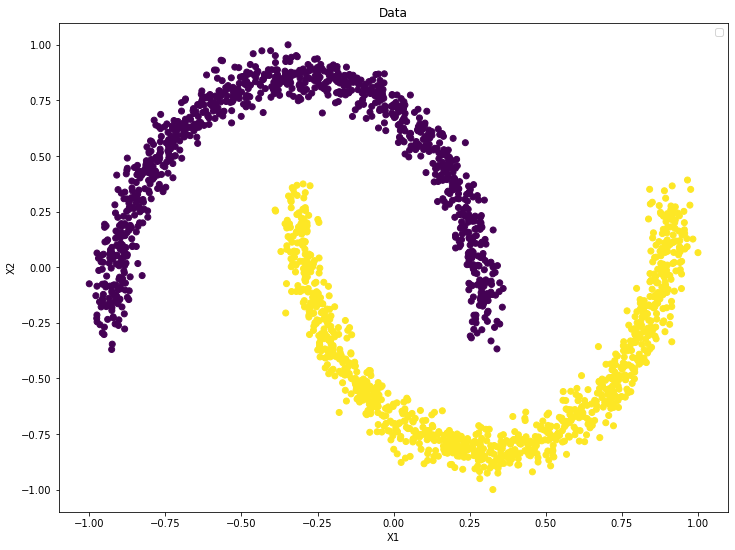

In [129]:
plt.figure(figsize=(12, 9))
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Data")
plt.legend()
plt.show()

### Using the Dataset to Test the Network

In [130]:
# set hyperparameters (play with these!)
layer_sizes = [32, 16, n_classes]
n_epochs = 5000
batch_size = 200
learning_rate = 0.003

# create network
network = MLP(n_features, layer_sizes)

# train
network.train(X_train, Y_train, n_epochs, batch_size, learning_rate)

# test
predicted_posteriors = network.forward(X_test)
# determine class predictions from posteriors by winner-takes-all rule
predicted_classes = np.argmax(predicted_posteriors, axis=-1)
# compute and output the error rate of predicted_classes

incorrect = predicted_classes != Y_test

error_rate = incorrect.sum() / len(incorrect)
print("error rate:", error_rate)



error rate: 0.0


### Visualizing the Decision Boundaries

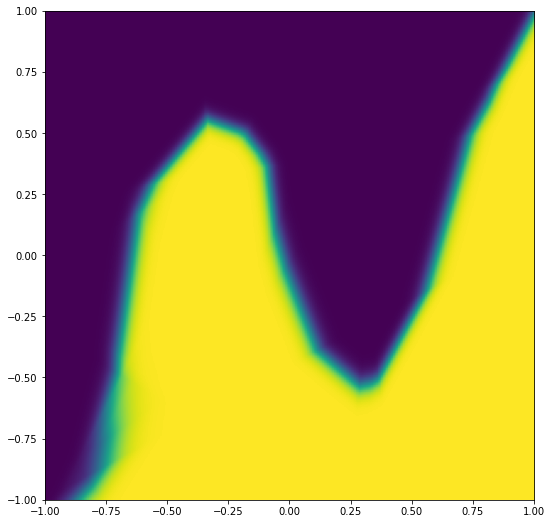

In [131]:
# full dataset
X = np.concatenate([X_train, X_test])
Y = np.concatenate([Y_train, Y_test])

# parameters for image plot

W = 200
H = 200
left = np.min(X[:, 0])
right = np.max(X[:, 0])
bottom = np.min(X[:, 1])
top = np.max(X[:, 1])
x = np.linspace(left, right, W)
y = np.linspace(bottom, top, H)

xx, yy = np.meshgrid(x, y)

X_grid = np.stack([xx.flat, yy.flat]).T

predictions = network.forward(X_grid)
predictions = np.asarray(predictions)
classes = np.argmax(predictions, axis=-1)

classes = classes.reshape((W, H))
predictions = predictions.reshape((W, H, 2))

# image plot of decision boundaries

plt.figure(figsize=(10, 9))
plt.imshow(predictions[:, :, 1], extent=(left, right, bottom, top), origin="lower")

All instances were correctly classified (small green dots)

No instances were incorrectly classified (big red dots)

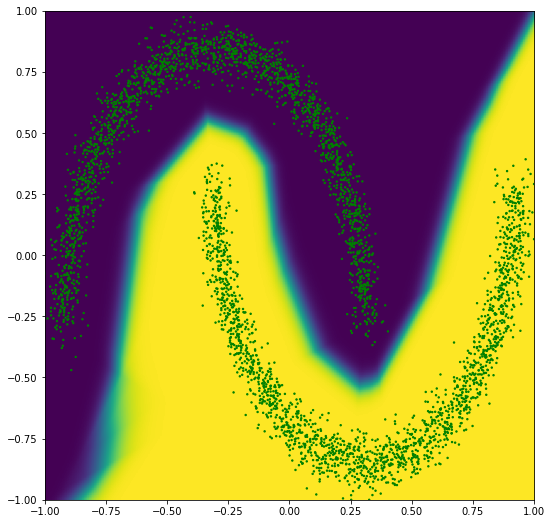

In [132]:
# scatter for correctly and incorrectly classified instances

all_predictions = network.forward(X)
all_predictions = np.asarray(all_predictions)
all_classes = np.argmax(all_predictions, axis=-1)
all_correct = all_classes == Y

colours = np.where(all_correct, "green", "red")
sizes = np.where(all_correct, 2, 20)

plt.figure(figsize=(10, 9))
plt.imshow(predictions[:, :, 1], extent=(left, right, bottom, top), origin="lower")
plt.scatter(X[:, 0], X[:, 1], s=sizes, c=colours)

plt.show()


### Comparing Validation Errors

Even the networks with few neurons produce surprisingly good results.
In our tests, merely 5 neurons were necessary to achieve 0 validation error.

Surprisingly, multi-layer networks did not significantly outperform their single-layer counterparts
(with same total number of neurons). When retrying the experiment with a smaller `n_epochs`, we also
found that single-layer networks of equivalent size converge more quickly on this dataset.

Networks with more neurons perform better (given that they have converged), which is to be expected.

In [140]:
layers = [
    [2],
    [3],
    [4],
    [2, 2],
    [5],
    [6],
    [3, 3],
    [10],
    [5, 5],
    [30],
    [60],
    [30, 30],
    [1000]
]

n_epochs = 1000

X_validate, Y_validate = make_dataset(N)

for layer in layers:
    network = MLP(n_features, layer + [n_classes])
    network.train(X_train, Y_train, n_epochs, batch_size, learning_rate)

    # validate
    predicted_posteriors = network.forward(X_validate)
    # determine class predictions from posteriors by winner-takes-all rule
    predicted_classes = np.argmax(predicted_posteriors, axis=-1)
    # compute and output the error rate of predicted_classes

    incorrect = predicted_classes != Y_validate

    error_rate = incorrect.sum() / len(incorrect)

    print("Layer", layer)
    print("error rate:", error_rate)
    print("========================")


Layer [2]
error rate: 0.112
Layer [3]
error rate: 0.1135
Layer [4]
error rate: 0.0
Layer [2, 2]
error rate: 0.5
Layer [5]
error rate: 0.0
Layer [6]
error rate: 0.0
Layer [3, 3]
error rate: 0.097
Layer [10]
error rate: 0.0
Layer [5, 5]
error rate: 0.1065
Layer [30]
error rate: 0.0
Layer [60]
error rate: 0.0
Layer [30, 30]
error rate: 0.0
Layer [1000]
error rate: 0.0
